# 🚀 Implementación Completa de un Modelo NLP
## Análisis de Sentimientos en Reviews de Amazon

### 🛠️ 1. Setup Inicial

In [1]:
# Importaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Librerías NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import spacy

# Procesamiento de texto
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# API
import pickle
from fastapi import FastAPI
from pydantic import BaseModel

# Descarga recursos NLTK necesarios
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ingen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ingen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ingen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 📊 2. Carga y Exploración de Datos

Información del Dataset:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Primeras 5 filas:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


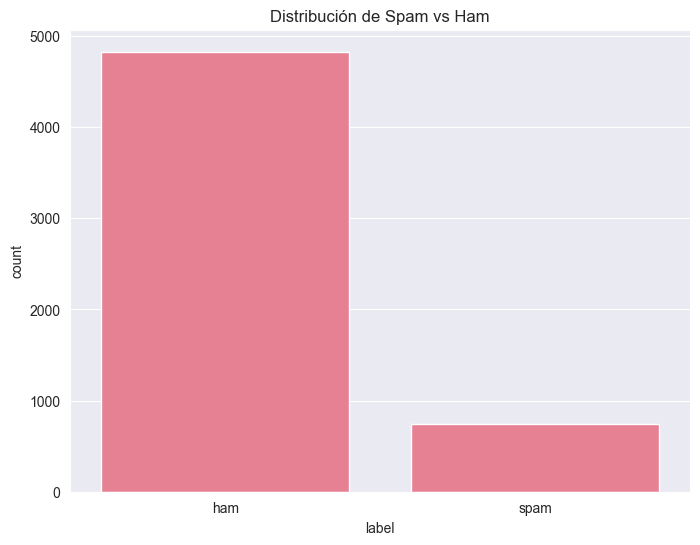

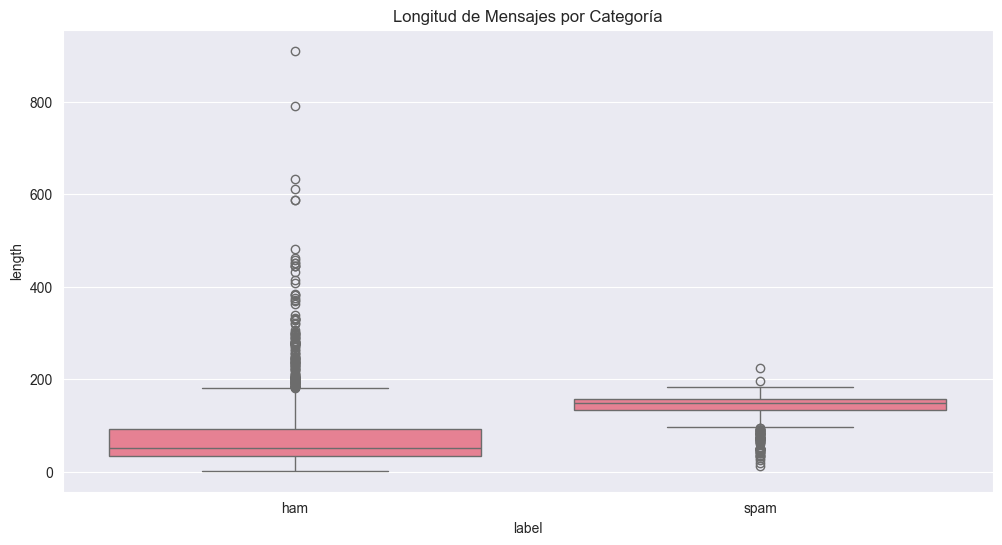

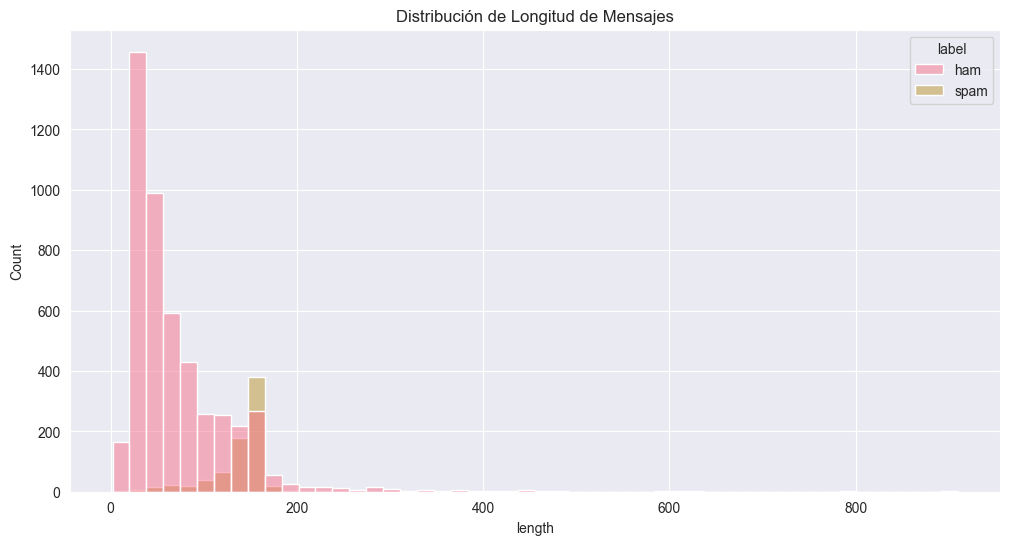


Estadísticas de longitud por categoría:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


In [2]:
# Cargar dataset
url = "https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"

df = pd.read_csv(url, encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})

# Mostrar información básica
print("Información del Dataset:")
print("-" * 50)
print(df.info())
print("\nPrimeras 5 filas:")
print(df.head())

# Análisis de distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribución de Spam vs Ham')
plt.show()

# Análisis de longitud de mensajes
df['length'] = df['message'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='label', y='length')
plt.title('Longitud de Mensajes por Categoría')
plt.show()

# Distribución de longitud de mensajes
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='length', hue='label', bins=50)
plt.title('Distribución de Longitud de Mensajes')
plt.show()

# Estadísticas descriptivas
print("\nEstadísticas de longitud por categoría:")
print(df.groupby('label')['length'].describe())

### 🧹 3. Preprocesamiento

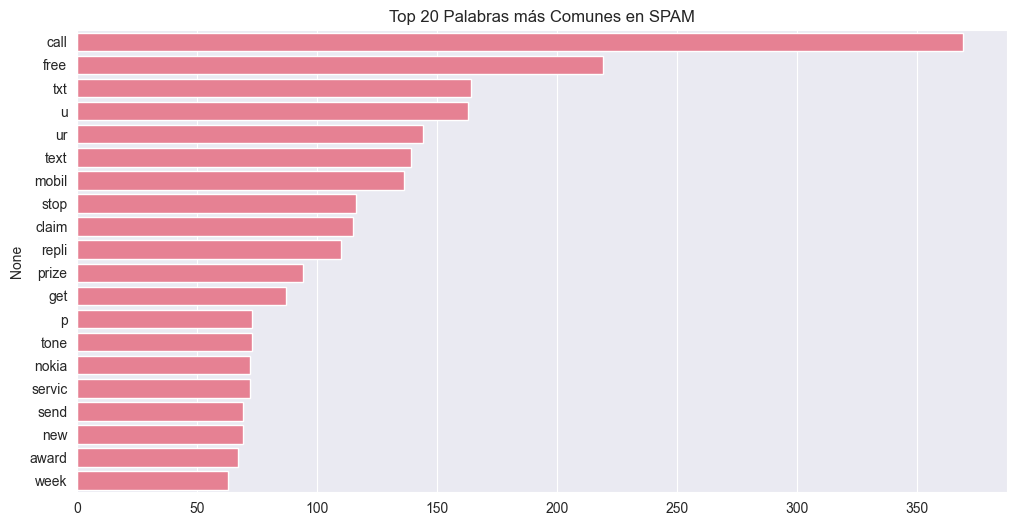

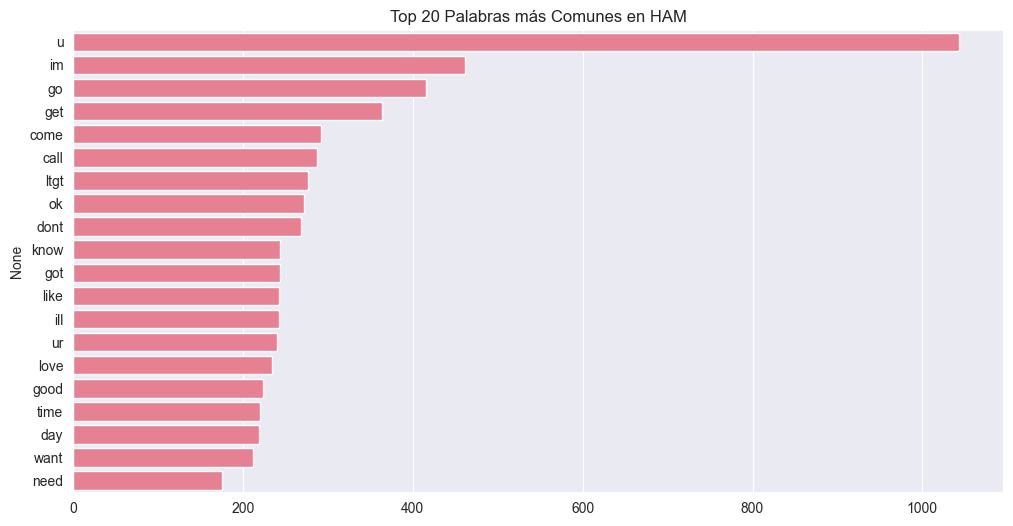

In [3]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar números y puntuación
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Aplicar preprocesamiento
df['processed_text'] = df['message'].apply(lambda x: preprocess_text(x))

# tqdm.pandas()

# df['processed_text'] = df['message'].progress_apply(preprocess_text)

# Visualizar palabras más comunes por categoría
def plot_common_words(texts, title, n=20):
    words = ' '.join(texts).split()
    word_freq = pd.Series(words).value_counts()[:n]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=word_freq.values, y=word_freq.index)
    plt.title(title)
    plt.show()

# Palabras más comunes en spam y ham
for label in ['spam', 'ham']:
    plot_common_words(
        df[df['label'] == label]['processed_text'],
        f'Top 20 Palabras más Comunes en {label.upper()}'
    )

### ⚡ 4. Vectorización y División de Datos

In [4]:
# Preparar datos para el modelo
X = df['processed_text']
y = df['label']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Crear pipeline de procesamiento
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('classifier', MultinomialNB())
])

# Visualizar dimensiones
print("Dimensiones del conjunto de datos:")
print(f"Training: {len(X_train)} muestras")
print(f"Testing: {len(X_test)} muestras")

Dimensiones del conjunto de datos:
Training: 4457 muestras
Testing: 1115 muestras


### 🤖 5. Modelado y Evaluación


Reporte de Clasificación:
--------------------------------------------------
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



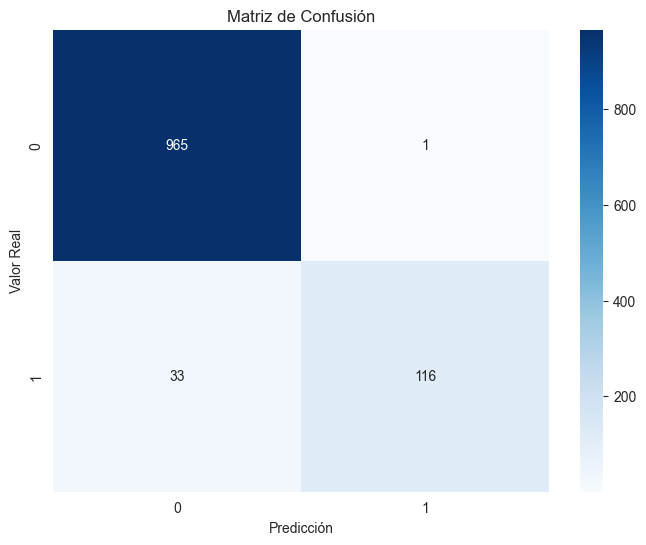


Ejemplos de clasificaciones incorrectas:
                                                mensaje  real predicho
5     freemsg hey darl week word back id like fun st...  spam      ham
1021  guess somebodi know secretli fanci wan na find...  spam      ham
855   talk sexi make new friend fall love world disc...  spam      ham
1662  hi ur lookin sauci daytim fun wiv busti marri ...  spam      ham
3979                                          ringtonek  spam      ham


In [5]:
# Entrenar modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones
y_pred = pipeline.predict(X_test)

# Evaluar modelo
print("\nReporte de Clasificación:")
print("-" * 50)
print(classification_report(y_test, y_pred))

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Análisis de errores
errors = pd.DataFrame({
    'mensaje': X_test[y_test != y_pred],
    'real': y_test[y_test != y_pred],
    'predicho': y_pred[y_test != y_pred]
})

print("\nEjemplos de clasificaciones incorrectas:")
print(errors.head())

### ⚙️ 6. Optimización

In [6]:
from sklearn.model_selection import GridSearchCV

# Definir pipeline para optimización
pipeline_opt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Definir parámetros para búsqueda
parameters = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__min_df': [1, 2, 3],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

# Realizar búsqueda de grid
grid_search = GridSearchCV(
    pipeline_opt,
    parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Mostrar mejores parámetros
print("\nMejores parámetros:")
print(grid_search.best_params_)

# Evaluar modelo optimizado
y_pred_opt = grid_search.predict(X_test)
print("\nReporte de Clasificación (Modelo Optimizado):")
print(classification_report(y_test, y_pred_opt))

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Mejores parámetros:
{'classifier__alpha': 0.1, 'tfidf__max_features': 2000, 'tfidf__min_df': 1}

Reporte de Clasificación (Modelo Optimizado):
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



### 🚀 7. Preparación para Producción

In [7]:
from fastapi import FastAPI
from pydantic import BaseModel
import pickle

# Clase para entrada de API
class SMSInput(BaseModel):
    message: str

# Guardar modelo
with open('spam_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

# Crear API
app = FastAPI()

@app.post("/predict")
async def predict_spam(sms: SMSInput):
    # Preprocesar
    processed_text = preprocess_text(sms.message)
    
    # Predecir
    prediction = grid_search.best_estimator_.predict([processed_text])[0]
    probability = grid_search.best_estimator_.predict_proba([processed_text])[0]
    
    return {
        "prediction": prediction,
        "spam_probability": float(probability[1]),
        "ham_probability": float(probability[0])
    }

# Código para archivo api.py
"""
import uvicorn

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
"""

'\nimport uvicorn\n\nif __name__ == "__main__":\n    uvicorn.run(app, host="0.0.0.0", port=8000)\n'

### 📊 8. Ejemplo de Uso y Monitoreo

In [8]:
# Ejemplo de uso del modelo
def classify_sms(message):
    processed = preprocess_text(message)
    prediction = grid_search.best_estimator_.predict([processed])[0]
    probs = grid_search.best_estimator_.predict_proba([processed])[0]
    
    return {
        'mensaje': message,
        'predicción': prediction,
        'probabilidad_spam': probs[1]
    }

# Ejemplos de prueba
mensajes_prueba = [
    "WINNER!! As a valued customer you have been selected to receive a £1000 prize reward!",
    "Hey, what time is the meeting tomorrow?",
    "FREE ENTRY into our £250 weekly competition! Just text WINNER to 87070.",
    "I'll be home in 20 minutes, need anything from the store?"
]

for mensaje in mensajes_prueba:
    resultado = classify_sms(mensaje)
    print("\nMensaje:", resultado['mensaje'])
    print("Clasificación:", resultado['predicción'])
    print(f"Probabilidad de spam: {resultado['probabilidad_spam']:.2%}")


Mensaje: WINNER!! As a valued customer you have been selected to receive a £1000 prize reward!
Clasificación: spam
Probabilidad de spam: 99.95%

Mensaje: Hey, what time is the meeting tomorrow?
Clasificación: ham
Probabilidad de spam: 0.45%

Mensaje: FREE ENTRY into our £250 weekly competition! Just text WINNER to 87070.
Clasificación: spam
Probabilidad de spam: 99.87%

Mensaje: I'll be home in 20 minutes, need anything from the store?
Clasificación: ham
Probabilidad de spam: 0.26%


### 📈 Monitoreo de Rendimiento

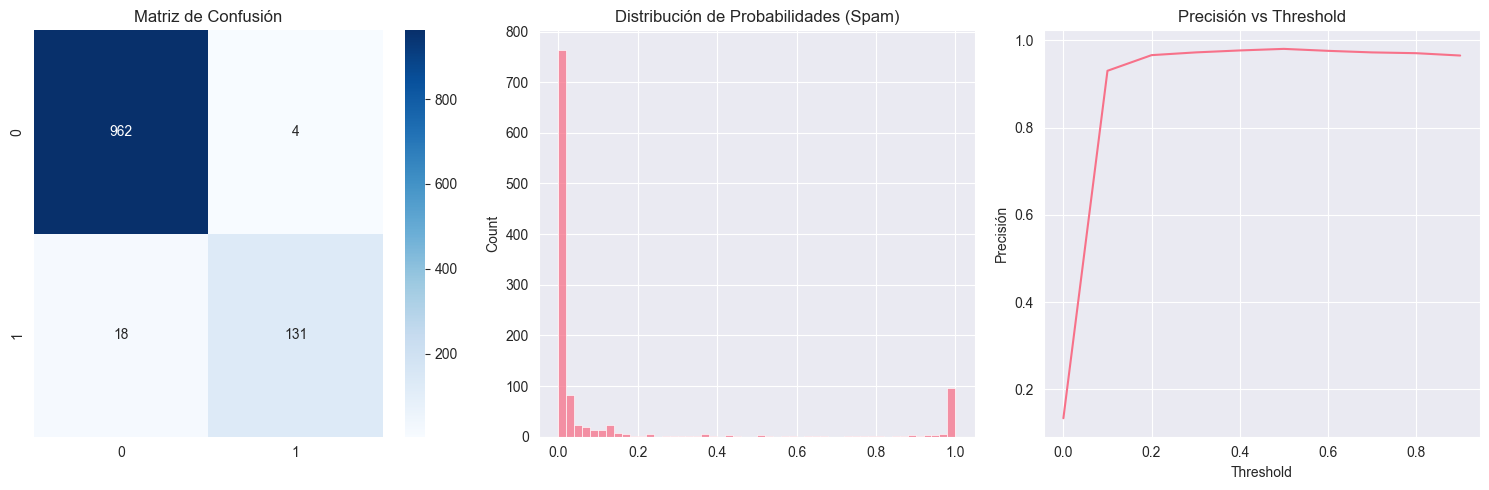

In [9]:
# Función para monitorear el rendimiento del modelo
def monitor_model_performance(y_true, y_pred, y_prob):
    # Precisión por clase
    plt.figure(figsize=(15, 5))
    
    # Matriz de confusión
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    
    # Distribución de probabilidades
    plt.subplot(1, 3, 2)
    sns.histplot(y_prob[:, 1], bins=50)
    plt.title('Distribución de Probabilidades (Spam)')
    
    # Precisión vs Threshold
    thresholds = np.arange(0, 1, 0.1)
    precisions = []
    for thresh in thresholds:
        y_pred_thresh = (y_prob[:, 1] >= thresh).astype(int)
        prec = (y_true == y_pred_thresh).mean()
        precisions.append(prec)
    
    plt.subplot(1, 3, 3)
    plt.plot(thresholds, precisions)
    plt.title('Precisión vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Precisión')
    
    plt.tight_layout()
    plt.show()

# Monitorear rendimiento actual
y_prob = grid_search.best_estimator_.predict_proba(X_test)
monitor_model_performance(
    y_test == 'spam',
    y_pred_opt == 'spam',
    y_prob
)

Este ejemplo:

1. **Usa un dataset más simple** pero perfecto para NLP
2. **Implementa todos los pasos** del instructivo
3. **Incluye visualizaciones relevantes** en cada etapa
4. **Prepara el modelo para producción** con FastAPI
5. **Incluye monitoreo** de rendimiento

Para ejecutar el código:

1. **Instalar dependencias**:
```bash
pip install pandas numpy scikit-learn nltk fastapi uvicorn seaborn
```

2. **Descargar el dataset**:
El código lo descarga automáticamente de GitHub

3. **Ejecutar el notebook**:
Copiar y pegar cada sección en celdas separadas de Jupyter